# Assignment 9 (Bài về nhà): Word embeddings cho bài toán hệ gợi ý
Tổng quan: Ở bài tập này chúng ta áp dụng word2vec cho bài toán hệ gợi ý. Sử dụng dữ liệu về lịch sử mua bán Online Retail Dataset (Online Retail.xlsx)

## Import Libraries and Load Data

In [ ]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

## Câu hỏi 1: khảo sát dữ liệu, xem dữ liệu có bao nhiêu bản ghi, bao nhiêu thuộc tính, xem dữ liệu của 5 bản ghi đầu tiên.


In [ ]:
#### YOUR CODE HERE ####

#### END YOUR CODE #####

## Xử lý dữ liệu với các giá trị missing

In [ ]:
# Kiểm tra các giá trị còn thiếu
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<br>
Loại bỏ tất cả các hàng dữ liệu bị missing values.

In [ ]:
# loại bỏ các giá trị missing
df.dropna(inplace=True)

# Một lần nữa kiểm tra các missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Chuẩn bị dữ liệu

Chuyển StockCode thành kiểu dữ liệu string

In [ ]:
df['StockCode']= df['StockCode'].astype(str)

Kiểm tra số lượng khách hàng trong tập dataset

In [ ]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

Có tổng cộng 4,372 khác hàng trong bộ dataset. Với mỗi khách hàng chúng ta sẽ trích xuất lịch sử mua bán của họ. Hay nói cách khác chúng ta sẽ có 4,372 chuỗi mua hàng.

Với tập dữ liệu đầu vào, chúng ta sử dụng dữ liệu của 90% khách hàng để tạo word2vec embeddings, số còn lại ta dùng để đánh giá. Vì vậy ta xử lý liệu như sau:

In [ ]:
# Trộn ID của khách hàng
# YOUR CODE HERE

# END YOUR CODE

# Lấy 80% ID của khác hàng
# YOUR CODE HERE

# END YOUR CODE

# Chia tập dữ liệu thành bộ train và validation
# YOUR CODE HERE

# END YOUR CODE

Tạo chuỗi mua hàng của các khách hàng trong hai tập train và validation

In [ ]:
purchases_train = []

# điền mã sản phẩm vào danh sách tập train
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:05<00:00, 683.41it/s]


In [ ]:
purchases_val = []

# điền mã sản phẩm vào danh sách tập validation
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 792.21it/s]


## Câu hỏi 2: Xây dựng mô hình biểu diễn cho các sản phẩm trong bộ dữ liệu train:
- Xây dựng mô hình, sử dụng Word2Vec(), với các tham số: window = 8, sg = 1, hs = 0, negative = 10, alpha=0.03, min_alpha=0.0007, seed = 14
- Xây dựng vocab cho mô hình, sử dụng build_vocab() cho model với bộ dữ liệu train và tham số progress_per=200
- Training cho model, sử dụng train() trên tập dữ liệu train, với các tham số total_examples = model.corpus_count, epochs=10, report_delay=1


In [ ]:
#### YOUR CODE HERE ####

#### END YOUR CODE #####

(3562185, 3597800)

In [ ]:
# lưu word2vec model
#### YOUR CODE HERE ####

#### END YOUR CODE #####

Vì chúng ta không train mô hình thêm nữa, nên chúng ta gọi init_sims(), để giúp mô hình thêm hiệu quả về bộ nhớ.

In [ ]:
model.init_sims(replace=True)

In [ ]:
print(model)

Word2Vec(vocab=3158, size=100, alpha=0.03)


Bây giờ ta sẽ trích xuất vector của tất cả các từ trong vocab, và lưu chúng lại một nơi để dễ dàng truy cập.

In [ ]:
X = model[model.wv.vocab]

X.shape

(3158, 100)

##  Visualize word2vec Embeddings

Visualize kết quả word2vec sử dụng thuật toán UMAP. Ở đây, vì mỗi vector có số chiều là 100, nên ta chuyển chúng về 2 chiều để hiển thị.


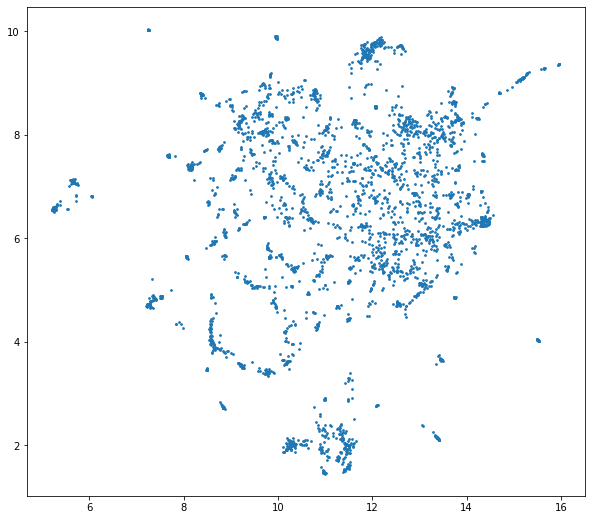

In [ ]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

Mỗi một điểm trong hình là của một sản phẩm. Chúng ta có thể thấy rằng, có nhiều cụm của các sản phẩm giống nhau.

## Bắt đầu gợi ý các sản phẩm

Đến đây, chúng ta đã có word2vec embeddings cho từng sản phẩm trong bộ dữ liệu Online Retail. Bước tiếp theo, ta sẽ gợi ý các sản phẩm tương tự cho một sản phẩm.

Đầu tiên, tạo một từ điển về ID và mô tả của phẩm để dễ dàng map một mô tả sản phẩm với ID của nó và ngược lại.

In [ ]:
products = train_df[["StockCode", "Description"]]

# Loại bỏ sự trùng lặp
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# Tạo từ điển
# YOUR CODE HERE

# END YOUR CODE

In [ ]:
# Kiểm tra từ điển
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

## Câu hỏi 3: Xây dựng hàm tính similarity của sản phẩm

Hàm nhận vào là vector của một sản phẩm cần gợi ý, đầu ra là 10 sản phẩm tương tự mà hệ thống sẽ gợi ý
Gợi ý:
 - Trích xuất ra những sản phẩm tương tự với sản phẩm đầu vào nhất
 - Trích xuất ra tên và độ tương tự của các sản phẩm ở trên (trong ms),
   và trả về giá trị cho hàm

In [ ]:
def similar_products(v, n = 10):
    
    #### YOUR CODE HERE ####

    #### END YOUR CODE #####
    

Thử hàm trên với một sản phẩm: '90019A' ('SILVER M.O.P ORBIT BRACELET')

In [ ]:
similar_products(model['90019A'])

[('BLACK VINTAGE  CRYSTAL EARRINGS', 0.7589031457901001),
 ('WHITE VINT ART DECO CRYSTAL NECKLAC', 0.7507529258728027),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7354578971862793),
 ('GOLD/M.O.P PENDANT ORBIT NECKLACE', 0.7343646287918091),
 ('GREEN HEART OF GLASS BRACELET', 0.7204496264457703),
 ('PINK BOUDICCA LARGE BRACELET', 0.7163015604019165)]

## Câu hỏi 4
Các kết quả trên khá tốt. Tuy nhiên, kết quả này dựa trên vector của chỉ một sản phẩm. Điều gì xảy ra nếu ta muốn gợi ý một khách hàng các sản phẩm dựa trên các sản phẩm khách hàng đã lựa chọn trước đó?

In [ ]:
#### YOUR CODE HERE ####


#### END YOUR CODE #####